<a href="https://colab.research.google.com/github/SruthiChilukuri/advanced_deep_learning/blob/master/simclrv2_using_utilityfunctions(scratch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2
# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [1]:
!nvidia-smi

Sun Sep 27 03:20:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

     - 19.5MB 10.3MB/s
     |████████████████████████████████| 163kB 4.7MB/s 
     |████████████████████████████████| 102kB 9.8MB/s 
     |████████████████████████████████| 122kB 15.1MB/s 
     |████████████████████████████████| 102kB 9.3MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
  Created wheel for wandb: filename=wandb-0.8.36-py2.py3-none-any.whl size=1385041 sha256=a0b2e23751a83a36ef5ddd7ca09b32ad6ab8f5a06bf29deb2fc83529cb1ec43c
  Stored in directory: /root/.cache/pip/wheels/6e/96/54/f4aafa18d112d4c6e313ac393b3b85513d090dd15b37357f19
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=80430a5c579d6969b773981571c127c71eabf1cddb4b4ae91b5588ae8d13180a
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73873 sha256=d388f225c569200d8445d0bd233303f1d2d05e5fee60

In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
from google.colab import auth
auth.authenticate_user()
PROJECT_ID = "fast-ai-exploration" 
!gcloud config set project $PROJECT_ID

Updated property [core/project].


In [5]:
!gsutil cp gs://resnet_simclr_imagenet/20200508-134915resnet_simclr.h5 .

AccessDeniedException: 403 srisruthi.chilukuri@sjsu.edu does not have storage.objects.list access to the Google Cloud Storage bucket.


In [6]:
simclr_weights = wandb.restore("20200509-042927resnet_simclr.h5", run_path="sayakpaul/simclr/simclr-learning")

In [8]:
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 48.83 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [9]:
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [10]:
train_images_10 = np.random.choice(train_images, len(train_images)//10)
len(train_images_10)

125

In [11]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [12]:
X_train, y_train = prepare_images(train_images_10)
X_test, y_test = prepare_images(test_images)

 10%|█         | 25/250 [00:00<00:00, 247.61it/s]

(125, 224, 224, 3) (125,)


100%|██████████| 250/250 [00:01<00:00, 212.84it/s]


(250, 224, 224, 3) (250,)


In [13]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [14]:
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [15]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights(simclr_weights.name)
resnet_simclr.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

In [17]:
def plot_training(H):
  with plt.xkcd():
		  plt.plot(H.history["loss"], label="train_loss")
		  plt.plot(H.history["val_loss"], label="val_loss")
		  plt.plot(H.history["accuracy"], label="train_acc")
		  plt.plot(H.history["val_accuracy"], label="val_acc")
		  plt.title("Training Loss and Accuracy")
		  plt.xlabel("Epoch #")
		  plt.ylabel("Loss/Accuracy")
		  plt.legend(loc="lower left")
		  plt.show()

In [18]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

In [19]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

In [20]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)
print(train_features.shape, test_features.shape)

(125, 128) (250, 128)


In [21]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/35
2/2 [==============================] - 0s 84ms/step - loss: 3.3724 - accuracy: 0.1680 - val_loss: 3.1350 - val_accuracy: 0.1720
Epoch 2/35
2/2 [==============================] - 0s 24ms/step - loss: 3.1815 - accuracy: 0.1600 - val_loss: 2.9783 - val_accuracy: 0.1800
Epoch 3/35
2/2 [==============================] - 0s 21ms/step - loss: 3.0161 - accuracy: 0.1920 - val_loss: 2.8328 - val_accuracy: 0.2160
Epoch 4/35
2/2 [==============================] - 0s 22ms/step - loss: 2.8594 - accuracy: 0.1920 - val_loss: 2.7004 - val_accuracy: 0.2320
Epoch 5/35
2/2 [==============================] - 0s 22ms/step - loss: 2.7196 - accuracy: 0.2000 - val_loss: 2.5794 - val_accuracy: 0.2320
Epoch 6/35
2/2 [==============================] - 0s 23ms/step - loss: 2.5859 - accuracy: 0.2000 - val_loss: 2.4737 - val_accuracy: 0.2400
Epoch 7/35
2/2 [==============================] - 0s 23ms/step - loss: 2.4669 - accuracy: 0.2240 - val_loss: 2.3792 - val_accuracy: 0.2640
Epoch 8/35
2/2 [===========

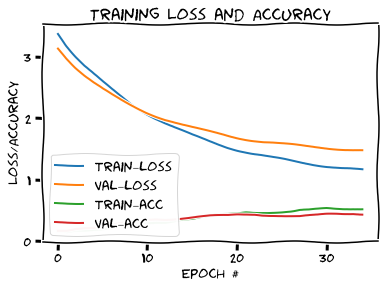

In [22]:
wandb.init(project="simclr", id="linear-eval-relu-last")

linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

In [23]:
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)
print(train_features.shape, test_features.shape)

(125, 256) (250, 256)


wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/35
2/2 [==============================] - 0s 71ms/step - loss: 4.0213 - accuracy: 0.2640 - val_loss: 3.3661 - val_accuracy: 0.3000
Epoch 2/35
2/2 [==============================] - 0s 28ms/step - loss: 3.4897 - accuracy: 0.2560 - val_loss: 2.9623 - val_accuracy: 0.3280
Epoch 3/35
2/2 [==============================] - 0s 27ms/step - loss: 3.1133 - accuracy: 0.3120 - val_loss: 2.6775 - val_accuracy: 0.3040
Epoch 4/35
2/2 [==============================] - 0s 25ms/step - loss: 2.8062 - accuracy: 0.3120 - val_loss: 2.4585 - val_accuracy: 0.3320
Epoch 5/35
2/2 [==============================] - 0s 24ms/step - loss: 2.5482 - accuracy: 0.3200 - val_loss: 2.2712 - val_accuracy: 0.3320
Epoch 6/35
2/2 [==============================] - 0s 24ms/step - loss: 2.3196 - accuracy: 0.3280 - val_loss: 2.1227 - val_accuracy: 0.3240
Epoch 7/35
2/2 [==============================] - 0s 31ms/step - loss: 2.1493 - accuracy: 0.3520 - val_loss: 2.0059 - val_accuracy: 0.3280
Epoch 8/35
2/2 [===========

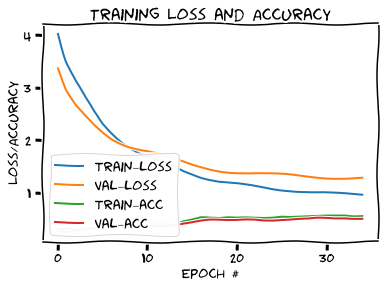

In [24]:
wandb.init(project="simclr", id="linear-eval-relu-second-last")
linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)


In [25]:
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)
print(train_features.shape, test_features.shape)

(125, 2048) (250, 2048)


wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/35
2/2 [==============================] - 0s 64ms/step - loss: 3.0755 - accuracy: 0.1440 - val_loss: 2.4603 - val_accuracy: 0.0840
Epoch 2/35
2/2 [==============================] - 0s 26ms/step - loss: 2.2124 - accuracy: 0.1600 - val_loss: 2.0175 - val_accuracy: 0.2240
Epoch 3/35
2/2 [==============================] - 0s 25ms/step - loss: 1.8621 - accuracy: 0.2320 - val_loss: 1.7975 - val_accuracy: 0.2240
Epoch 4/35
2/2 [==============================] - 0s 26ms/step - loss: 1.5169 - accuracy: 0.3280 - val_loss: 1.3798 - val_accuracy: 0.4760
Epoch 5/35
2/2 [==============================] - 0s 23ms/step - loss: 1.3150 - accuracy: 0.4400 - val_loss: 1.3169 - val_accuracy: 0.5120
Epoch 6/35
2/2 [==============================] - 0s 24ms/step - loss: 1.2284 - accuracy: 0.5200 - val_loss: 1.2450 - val_accuracy: 0.5320
Epoch 7/35
2/2 [==============================] - 0s 25ms/step - loss: 1.1217 - accuracy: 0.5440 - val_loss: 1.2004 - val_accuracy: 0.5640
Epoch 8/35
2/2 [===========

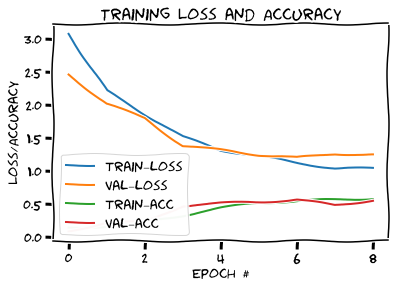

In [26]:
wandb.init(project="simclr", id="linear-eval-no-projections")
linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

In [27]:
wandb.init(project="simclr", id="visualization")

wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/sruthi_ch/simclr/runs/visualization

In [28]:
def plot_vecs_n_labels(v, labels):
    fig = plt.figure(figsize = (10, 10))
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 5))
    plt.show()

    return fig

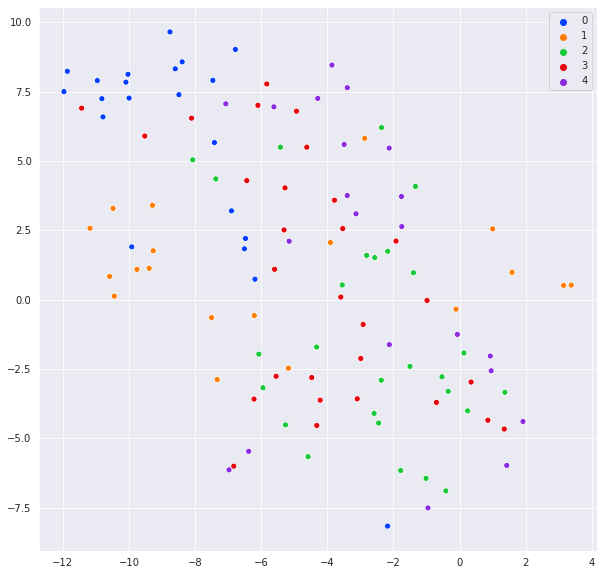

wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [29]:
tsne = TSNE()
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"no_no_linear_projection": fig})

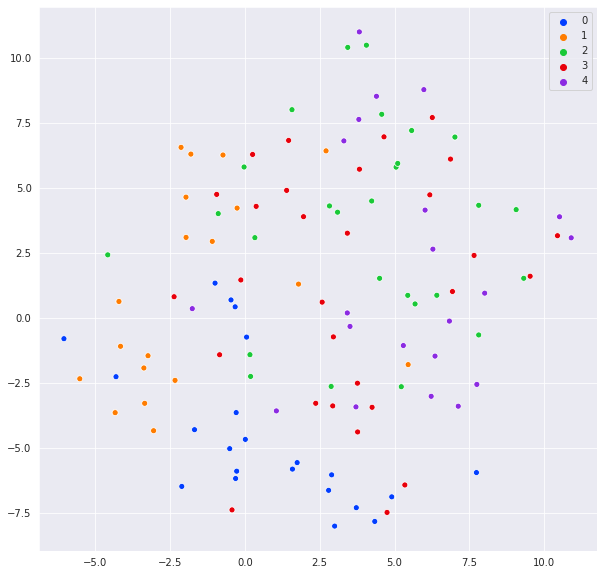

wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [30]:
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"last_relu": fig})